In [1]:
!unzip open.zip

Archive:  open.zip
  inflating: sample_submission.csv   
  inflating: test_data.csv           
  inflating: topic_dict.csv          
  inflating: train_data.csv          


In [2]:
!pip install transformers

     |████████████████████████████████| 2.6 MB 7.2 MB/s 
     |████████████████████████████████| 3.3 MB 49.3 MB/s 
     |████████████████████████████████| 636 kB 65.3 MB/s 
     |████████████████████████████████| 895 kB 62.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [12]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import warnings

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

from transformers import AutoTokenizer, AutoModelWithLMHead, GPT2ForSequenceClassification,AutoModel

warnings.filterwarnings('ignore')

In [4]:
tr = pd.read_csv('train_data.csv', index_col='index')

In [70]:
# tokenizer = AutoTokenizer.from_pretrained("skt/kogpt2-base-v2")
tokenizer=AutoTokenizer.from_pretrained('monologg/kobert')

# model = GPT2ForSequenceClassification.from_pretrained("skt/kogpt2-base-v2")
model=AutoModel.from_pretrained('monologg/kobert')

model.score = torch.nn.Linear(768, 7)
model.cuda()

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Some weights of the model checkpoint at skt/kogpt2-base-v2 were not used when initializing GPT2ForSequenceClassification: ['lm_head.weight']
- This IS expected if you are initializing GPT2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at skt/kogpt2-base-v2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predi

GPT2ForSequenceClassification(
  (transformer): GPT2Model(
    (wte): Embedding(51200, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=Fal

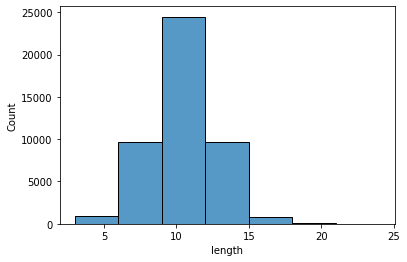

In [62]:
tr['length']=tr['title'].apply(lambda line:len(tokenizer.encode(line)))

import seaborn as sns

sns.histplot(data=tr, x="length", binwidth=3)

In [63]:
class TrainDataset(Dataset):
    def __init__(self, data, tokenizer, max_seq_len=40): ## 40 수정.
        self.data = data
        self.max_seq_len = max_seq_len
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        record = self.data.iloc[index]
        document, label = str(record['title']), int(record['topic_idx'])
        tokens = self.tokenizer.tokenize(document)
        encoder_input_id = self.tokenizer.convert_tokens_to_ids(tokens)
        attention_mask = [1] * len(encoder_input_id)
        if len(encoder_input_id) < self.max_seq_len:
            while len(encoder_input_id) < self.max_seq_len:
                encoder_input_id += [tokenizer.convert_tokens_to_ids('<pad>')]
                # encoder_input_id += [tokenizer.convert_tokens_to_ids('[PAD]')]
                attention_mask += [0]
        else:
            encoder_input_id = encoder_input_id[:self.max_seq_len - 1] + [
                self.tokenizer.eos_token_id]
            attention_mask = attention_mask[:self.max_seq_len]
        return {'input_ids': np.array(encoder_input_id, dtype=np.int_),
                'attention_mask': np.array(attention_mask, dtype=np.float),
                'labels': np.array(label, dtype=np.int_)}


In [64]:
class TestDataset(Dataset):
    def __init__(self, data, tokenizer, max_seq_len=40):
        self.data = data
        self.max_seq_len = max_seq_len
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        record = self.data.iloc[index]
        document = str(record['title'])
        tokens = self.tokenizer.tokenize(document)
        encoder_input_id = self.tokenizer.convert_tokens_to_ids(tokens)
        attention_mask = [1] * len(encoder_input_id)
        if len(encoder_input_id) < self.max_seq_len:
            while len(encoder_input_id) < self.max_seq_len:
                encoder_input_id += [tokenizer.convert_tokens_to_ids('<pad>')]
                # encoder_input_id += [tokenizer.convert_tokens_to_ids('[PAD]')]
                attention_mask += [0]
        else:
            encoder_input_id = encoder_input_id[:self.max_seq_len - 1] + [
                self.tokenizer.eos_token_id]
            attention_mask = attention_mask[:self.max_seq_len]
        return {'input_ids': np.array(encoder_input_id, dtype=np.int_),
                'attention_mask': np.array(attention_mask, dtype=np.float)}

In [65]:
# train parameters
epochs = 10
batch_size = 32

In [66]:
# train loader
train_ds = TrainDataset(tr, tokenizer)
loader = DataLoader(train_ds, batch_size=batch_size, num_workers=0, shuffle=True)

In [67]:
# optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 5, )
loss_fn = torch.nn.CrossEntropyLoss()

In [21]:
model.train()
for e in range(epochs):
    total_loss = 0
    for batch in loader:
        optimizer.zero_grad()
        ids, atts, labels = batch['input_ids'], batch['attention_mask'], batch['labels']
        ids = torch.tensor(ids).long().cuda()
        atts = torch.tensor(atts).long().cuda()
        labels = torch.tensor(labels).long().cuda()
        pred = model(ids, attention_mask=atts)
        loss = loss_fn(pred[0], labels)
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.)
        optimizer.step()
        total_loss += loss.item()
        
    scheduler.step()
    print(e, total_loss)

RuntimeError: ignored

In [ ]:
# test loader
te = pd.read_csv('./data/test_data.csv', index_col='index')

test_ds = TestDataset(te, tokenizer)
test_loader = DataLoader(test_ds, 8)

In [ ]:
preds = []
model.eval()

for b in tqdm(test_loader):
    ids, atts = b['input_ids'], b['attention_mask']
    ids = torch.tensor(ids).long().cuda()
    atts = torch.tensor(atts).long().cuda()
    pred = model(ids, attention_mask=atts)
    preds += list(np.argmax(pred[0].detach().cpu().numpy(), 1))
#     break

In [ ]:
sub = pd.read_csv('sample_submission.csv', index_col='index')
sub['topic_idx'] = preds
sub.head(20)

In [ ]:
sub.to_csv('gpt.csv')

In [118]:
## kobert

!pip install mxnet
!pip install gluonnlp pandas tqdm
!pip install sentencepiece
!pip install transformers==3.0.2
!pip install torch

     |████████████████████████████████| 769 kB 8.2 MB/s 
     |████████████████████████████████| 3.0 MB 62.4 MB/s 
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.10.3
    Uninstalling tokenizers-0.10.3:
      Successfully uninstalled tokenizers-0.10.3
  Attempting uninstall: transformers
    Found existing installation: transformers 4.9.1
    Uninstalling transformers-4.9.1:
      Successfully uninstalled transformers-4.9.1


In [72]:
!pip install git+https://git@github.com/SKTBrain/KoBERT.git@master

  Cloning https://****@github.com/SKTBrain/KoBERT.git (to revision master) to /tmp/pip-req-build-ku4pjh58
  Running command git clone -q 'https://****@github.com/SKTBrain/KoBERT.git' /tmp/pip-req-build-ku4pjh58
  Created wheel for kobert: filename=kobert-0.1.2-py3-none-any.whl size=12770 sha256=d1d39dfa32e3dca7d51e09a5bde9a29eeee89e533c83533b64d974644a7088bb
  Stored in directory: /tmp/pip-ephem-wheel-cache-oqjzyu55/wheels/d3/68/ca/334747dfb038313b49cf71f84832a33372f3470d9ddfd051c0
Successfully built kobert


In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import numpy as np
from tqdm import tqdm, tqdm_notebook

In [2]:
from kobert.utils import get_tokenizer
from kobert.pytorch_kobert import get_pytorch_kobert_model

from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup

In [3]:
##GPU 사용 시
device = torch.device("cuda:0")

In [4]:
bertmodel, vocab = get_pytorch_kobert_model()

using cached model
using cached model


In [5]:
tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

using cached model


In [6]:
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, max_len,
                 pad, pair):
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len, pad=pad, pair=pair)

        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))

In [10]:
import pandas as pd
data=pd.read_csv('train_data.csv',index_col='index')

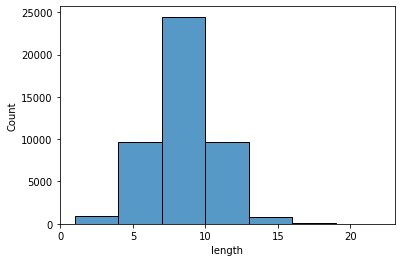

In [11]:
data['length']=data['title'].apply(lambda line:len(tok.basic_tokenizer(line)))

import seaborn as sns

sns.histplot(data=data, x="length", binwidth=3)

In [12]:
## Setting parameters
# max_len = 64
max_len=30
batch_size = 64
warmup_ratio = 0.1
num_epochs = 5
max_grad_norm = 1
log_interval = 200
learning_rate =  5e-5

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data['title'],data['topic_idx'],test_size=0.33, random_state=42)

dataset_train=[]
dataset_test=[]

for i in X_train.index:
    dataset_train.append((X_train[i],y_train[i]))

for i in X_test.index:
    dataset_test.append((X_test[i],y_test[i]))

In [14]:
data_train = BERTDataset(dataset_train, 0, 1, tok, max_len, True, False)
data_test = BERTDataset(dataset_test, 0, 1, tok, max_len, True, False)

In [15]:
train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, num_workers=5)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, num_workers=5)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [16]:
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                #  num_classes=2
                 num_classes=7,
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
                 
        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)
    
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)

In [17]:
kobert_model = BERTClassifier(bertmodel,  dr_rate=0.5).to(device)

In [18]:
# Prepare optimizer and schedule (linear warmup and decay)
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in kobert_model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in kobert_model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

In [19]:
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

In [20]:
t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

In [21]:
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

In [22]:
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

In [23]:
for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    kobert_model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = kobert_model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(kobert_model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
    kobert_model.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = kobert_model(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy(out, label)
    print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch 1 batch id 1 loss 1.990034580230713 train acc 0.1875
epoch 1 batch id 201 loss 0.4044267237186432 train acc 0.617148631840796
epoch 1 batch id 401 loss 0.5386362075805664 train acc 0.7361284289276808

epoch 1 train acc 0.7574202405857741


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



epoch 1 test acc 0.8725197604302477


epoch 2 batch id 1 loss 0.39148348569869995 train acc 0.890625
epoch 2 batch id 201 loss 0.3044469952583313 train acc 0.8790422885572139
epoch 2 batch id 401 loss 0.44134312868118286 train acc 0.890430174563591

epoch 2 train acc 0.8923335076708507



epoch 2 test acc 0.8782441737288136


epoch 3 batch id 1 loss 0.1877519190311432 train acc 0.9375
epoch 3 batch id 201 loss 0.20851652324199677 train acc 0.9165111940298507
epoch 3 batch id 401 loss 0.28563210368156433 train acc 0.9244466957605985

epoch 3 train acc 0.9266344142259414



epoch 3 test acc 0.8867900505215124


epoch 4 batch id 1 loss 0.2496708482503891 train acc 0.9375
epoch 4 batch id 201 loss 0.17447087168693542 train acc 0.9449626865671642
epoch 4 batch id 401 loss 0.23031474649906158 train acc 0.9510598503740648

epoch 4 train acc 0.9533429218967923



epoch 4 test acc 0.8880479954367667


epoch 5 batch id 1 loss 0.11862562596797943 train acc 0.96875
epoch 5 batch id 201 loss 0.047030046582221985 train acc 0.9660292288557214
epoch 5 batch id 401 loss 0.13517169654369354 train acc 0.9700358478802993

epoch 5 train acc 0.9708028242677824



epoch 5 test acc 0.8875845420469362


In [103]:
test=pd.read_csv('test_data.csv',index_col='index')

transform = nlp.data.BERTSentenceTransform(tok, max_seq_length=max_len, pad=True, pair=False)

answer=[]

with torch.no_grad():
    kobert_model.eval()
    for sentence in test['title']:
        token_ids, valid_length, segment_ids=transform(sentence)
        token_ids=torch.tensor([token_ids],dtype=torch.int32).long().to(device)
        valid_length=torch.tensor([valid_length.tolist()],dtype=torch.int32)
        segment_ids=torch.tensor([segment_ids],dtype=torch.int32).long().to(device)

        pred=kobert_model(token_ids,valid_length,segment_ids)
        pred=pred.argmax().cpu().detach().numpy()
        
        answer.append(pred)

tensor(6, device='cuda:0')


In [85]:
submit=pd.read_csv('sample_submission.csv')

In [86]:
submit['topic_idx']=answer
submit.head()

,index,topic_idx
0,45654,6
1,45655,3
2,45656,2
3,45657,3
4,45658,2


In [87]:
submit.to_csv('20210802_kobert.csv',index=False)